In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.metrics import mean_squared_error
from sentence_transformers import SentenceTransformer
import joblib
import seaborn as sns

C:\Users\ashis\AppData\Local\Programs\Python\Python311\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
def evaluate_models(models, X_test, y_test):
    error_analysis = {}
    for model_name, model in models.items():
        print(f"Evaluating {model_name}...")
        y_pred = model.predict(X_test)
        cm=confusion_matrix(y_test, y_pred)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_proba))
        print(f"{model_name} RMSE: {rmse}")
        print(f"Accuracy of {model_name}:{accuracy_score(y_test,y_pred)}")
        print(f"\nClassification Report for {model_name}:\n", classification_report(y_test, y_pred))
        print(f"Confusion Matrix for {model_name}:\n")
        class_labels=[1,2,3,4,5]
        plt.figure(figsize=(8, 6))  
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title("Confusion Matrix")
        plt.show()
    return error_analysis

In [3]:
train_errors = []
val_errors = []
def hyperparameter_tuning(models, param_grids, X_train, y_train, X_test, y_test):
    best_estimators = {}
    i = 0
    for model_name, model in models.items():
        print(f"Optimizing {model_name}...")
        grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring='accuracy')
        grid_search.fit(X_train, y_train)
        best_estimators[model_name] = grid_search.best_estimator_
        print(f"Best params for {model_name}: {grid_search.best_params_}")
        print(f"\nGrid search results for {model_name}:")
        results = grid_search.cv_results_
        for mean_score, params in zip(results['mean_test_score'], results['params']):
            print(f"Params: {params} => Accuracy: {mean_score:.4f}")
        
        joblib.dump(best_estimators[model_name], f'{model_name}_best_model.joblib')
        
    return best_estimators

In [4]:
def split_set(X,y,test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0, stratify=y)
    return X_train, X_test, y_train, y_test

In [5]:
def load_feature(parquet_file,unifile,bifile):
    df = pd.read_parquet(parquet_file)
    display(df.head())
    emb = np.array(df['bert_text_embedding'].tolist())
    y = df['stars'].values
    un = pd.read_parquet(unifile)
    display(un.shape)
    emb1 = np.array(un['tfidf_u'].tolist())
    bi = pd.read_parquet(bifile)
    emb2 = np.array(bi['tfidf_ub'].tolist())
    display(bi.shape)
    X = np.hstack([emb, emb1, emb2])
    return X,y

In [6]:
X,y = load_feature('df_f_embeddings.parquet','df_tfidf_uni_embeddings_f.parquet','df_tfidf_bi_embeddings_f.parquet')

,text,stars,bert_text,bert_text_embedding,bert_pca
0,I LOVE Weaver's Way and really disagree with s...,5.0,i love way and really disagree with some of th...,"[0.033139758, -0.06937125, -0.021571362, 0.094...","[-0.027018651, -0.13602893, -0.055017352, -0.0..."
1,This is the first time I tried this place and ...,4.0,this be the first time i try this place and i ...,"[-0.004233606, -0.055537116, 0.09052298, 0.054...","[0.3555715, -0.00016833097, 0.10786091, -0.014..."
2,"I took the beginning class there, and I loved ...",5.0,i take the begin class there and i love it it ...,"[0.04014494, -0.038802896, 0.031918418, -0.016...","[0.05078724, -0.35743964, 0.097152926, 0.05306..."
3,Came in after attending the Zurich Classic gol...,4.0,come in after attend the zurich classic golf t...,"[0.04607378, 0.014579706, 0.0889094, 0.0553704...","[0.29594696, -0.280493, 0.049563676, 0.1280695..."
4,I've been wanting to try Trust Me BBQ for over...,2.0,be want to try trust me bbq for over a year no...,"[-0.025947846, -0.028238872, 0.0141912745, 0.0...","[0.17926002, 0.31022182, -0.08624919, -0.06297..."


(50000, 3)

(50000, 3)

In [7]:
X.shape

(50000, 484)

In [8]:
y.shape

(50000,)

In [9]:
X_train, X_test, y_train, y_test = split_set(X,y,0.25)

In [10]:
models = {
    'knn': KNeighborsClassifier()
}
param_grids = {
    'knn': {'n_neighbors': [11,15,19,21,23], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']},
}

# Perform hyperparameter tuning
best_estimators = hyperparameter_tuning(models, param_grids, X_train, y_train,X_test,y_test)

Optimizing knn...
Best params for knn: {'metric': 'manhattan', 'n_neighbors': 23, 'weights': 'distance'}

Grid search results for knn:
Params: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'} => Accuracy: 0.4353
Params: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'distance'} => Accuracy: 0.4380
Params: {'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'uniform'} => Accuracy: 0.4410
Params: {'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'distance'} => Accuracy: 0.4435
Params: {'metric': 'euclidean', 'n_neighbors': 19, 'weights': 'uniform'} => Accuracy: 0.4435
Params: {'metric': 'euclidean', 'n_neighbors': 19, 'weights': 'distance'} => Accuracy: 0.4447
Params: {'metric': 'euclidean', 'n_neighbors': 21, 'weights': 'uniform'} => Accuracy: 0.4456
Params: {'metric': 'euclidean', 'n_neighbors': 21, 'weights': 'distance'} => Accuracy: 0.4465
Params: {'metric': 'euclidean', 'n_neighbors': 23, 'weights': 'uniform'} => Accuracy: 0.4477
Params: {'metric': 'eucl

Evaluating knn...
knn RMSE: 3.1760850436712094
Accuracy of knn:0.462

Classification Report for knn:
               precision    recall  f1-score   support

         1.0       0.63      0.71      0.67      2500
         2.0       0.42      0.31      0.36      2500
         3.0       0.36      0.29      0.32      2500
         4.0       0.38      0.46      0.42      2500
         5.0       0.48      0.54      0.51      2500

    accuracy                           0.46     12500
   macro avg       0.45      0.46      0.45     12500
weighted avg       0.45      0.46      0.45     12500

Confusion Matrix for knn:



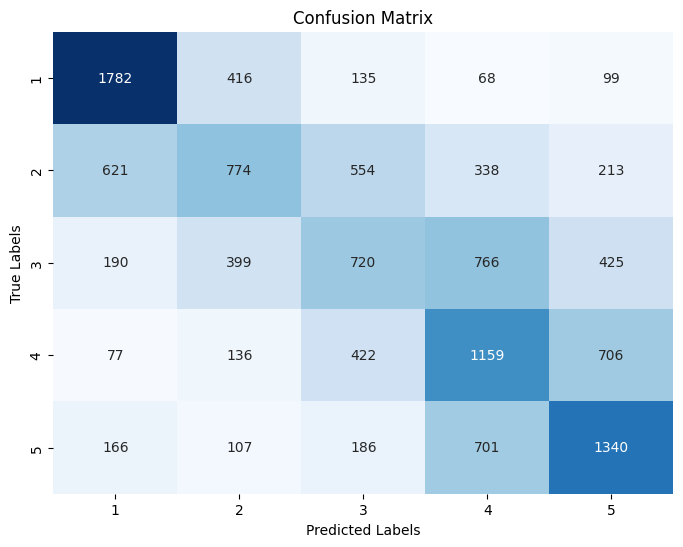

{}

In [11]:
evaluate_models(best_estimators, X_test, y_test)

In [12]:
models = {
    'logistic': LogisticRegression(max_iter=10000)
}
param_grids = {
    'logistic': {'C': [0.01, 0.1, 1, 10], 'penalty': ['l2'], 'solver': ['lbfgs','saga']},
}

# Perform hyperparameter tuning
best_estimators = hyperparameter_tuning(models, param_grids, X_train, y_train,X_test,y_test)

Optimizing logistic...
Best params for logistic: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}

Grid search results for logistic:
Params: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'} => Accuracy: 0.4886
Params: {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'} => Accuracy: 0.4885
Params: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'} => Accuracy: 0.5305
Params: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'} => Accuracy: 0.5304
Params: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'} => Accuracy: 0.5432
Params: {'C': 1, 'penalty': 'l2', 'solver': 'saga'} => Accuracy: 0.5434
Params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'} => Accuracy: 0.5428
Params: {'C': 10, 'penalty': 'l2', 'solver': 'saga'} => Accuracy: 0.5427


Evaluating logistic...
logistic RMSE: 3.180777891353537
Accuracy of logistic:0.54336

Classification Report for logistic:
               precision    recall  f1-score   support

         1.0       0.70      0.75      0.72      2500
         2.0       0.47      0.46      0.47      2500
         3.0       0.44      0.40      0.42      2500
         4.0       0.47      0.46      0.47      2500
         5.0       0.60      0.64      0.62      2500

    accuracy                           0.54     12500
   macro avg       0.54      0.54      0.54     12500
weighted avg       0.54      0.54      0.54     12500

Confusion Matrix for logistic:



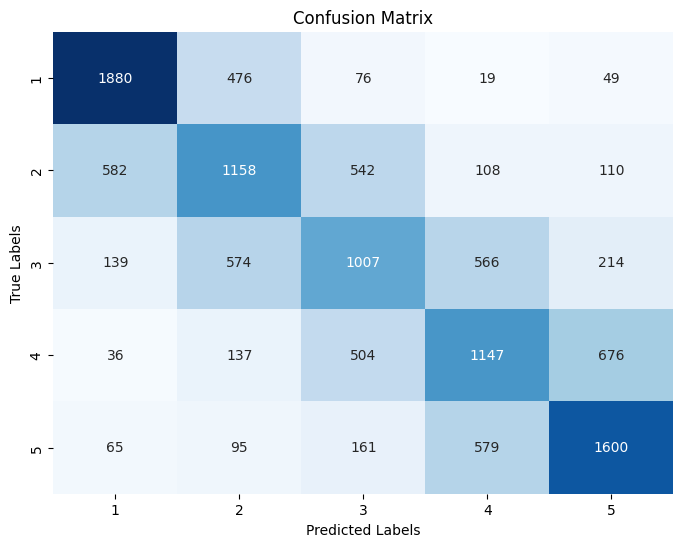

{}

In [13]:
evaluate_models(best_estimators, X_test, y_test)

Evaluating logistic...
logistic RMSE: 3.180777891353537
Accuracy of logistic:0.54336

Classification Report for logistic:
               precision    recall  f1-score   support

         1.0       0.70      0.75      0.72      2500
         2.0       0.47      0.46      0.47      2500
         3.0       0.44      0.40      0.42      2500
         4.0       0.47      0.46      0.47      2500
         5.0       0.60      0.64      0.62      2500

    accuracy                           0.54     12500
   macro avg       0.54      0.54      0.54     12500
weighted avg       0.54      0.54      0.54     12500

Confusion Matrix for logistic:



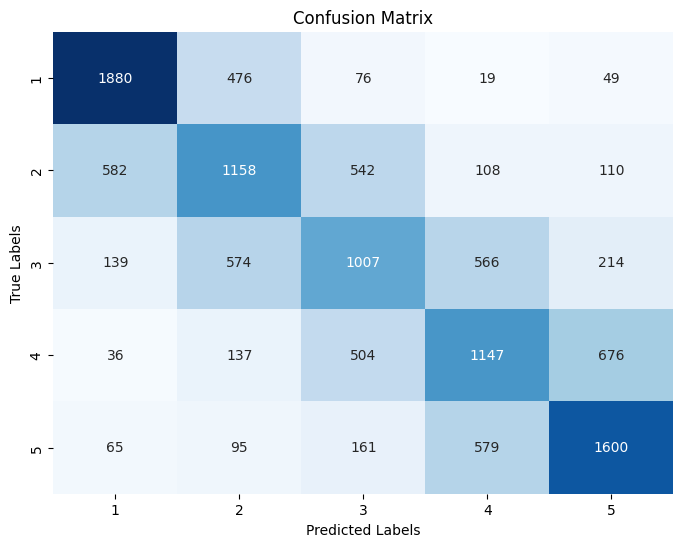

{}

In [15]:
evaluate_models(best_estimators, X_test, y_test)

In [19]:
from sklearn.naive_bayes import GaussianNB

models = {
    'naive_bayes': GaussianNB()
    
}

param_grids = {
    'naive_bayes': {},  
}
best_estimators = hyperparameter_tuning(models, param_grids, X_train, y_train,X_test,y_test)

Optimizing naive_bayes...
Best params for naive_bayes: {}

Grid search results for naive_bayes:
Params: {} => Accuracy: 0.4290


Evaluating naive_bayes...
naive_bayes RMSE: 3.238750782166055
Accuracy of naive_bayes:0.4292

Classification Report for naive_bayes:
               precision    recall  f1-score   support

         1.0       0.54      0.73      0.62      2500
         2.0       0.39      0.26      0.31      2500
         3.0       0.36      0.27      0.31      2500
         4.0       0.37      0.55      0.44      2500
         5.0       0.47      0.33      0.39      2500

    accuracy                           0.43     12500
   macro avg       0.42      0.43      0.41     12500
weighted avg       0.42      0.43      0.41     12500

Confusion Matrix for naive_bayes:



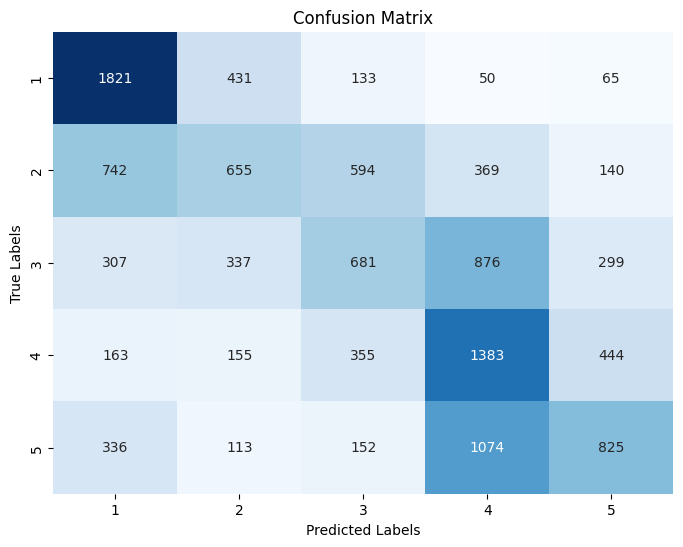

{}

In [20]:
evaluate_models(best_estimators, X_test, y_test)

In [21]:
from sklearn.ensemble import VotingClassifier
import joblib

knn = joblib.load('knnf.joblib')
lr = joblib.load('logisticf.joblib')
nb = joblib.load('naive_bayesf.joblib')
ensemble = VotingClassifier(
    estimators=[('knn', knn), ('lr', lr),('nb',nb)],
    voting='soft' t
)

ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)
accuracy_score(y_test, y_pred)

0.44736

In [22]:
from sklearn.ensemble import StackingClassifier

ensemble = StackingClassifier(
    estimators=[('knn', knn), ('lr', lr),('nb',nb)],
    final_estimator=LogisticRegression()
)

# Train and evaluate
ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)
accuracy_score(y_test, y_pred)

0.54672

Evaluating ensemble...
ensemble RMSE: 3.183092917488368
Accuracy of ensemble:0.54672

Classification Report for ensemble:
               precision    recall  f1-score   support

         1.0       0.71      0.74      0.73      2500
         2.0       0.47      0.48      0.47      2500
         3.0       0.43      0.41      0.42      2500
         4.0       0.48      0.46      0.47      2500
         5.0       0.62      0.64      0.63      2500

    accuracy                           0.55     12500
   macro avg       0.54      0.55      0.55     12500
weighted avg       0.54      0.55      0.55     12500

Confusion Matrix for ensemble:



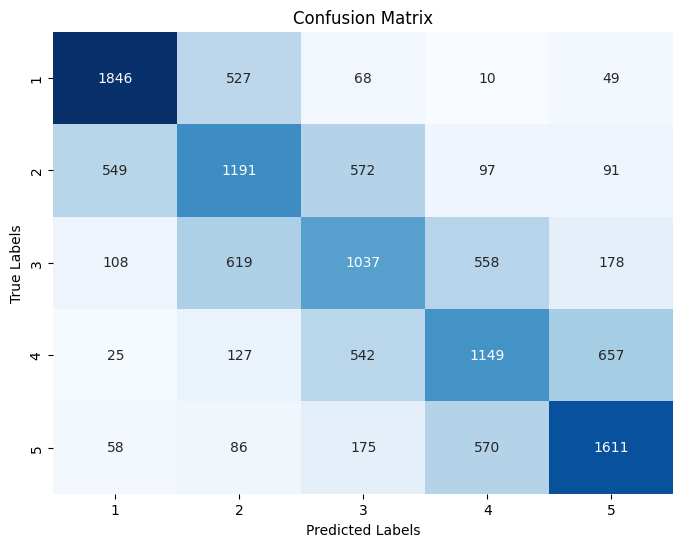

{}

In [24]:
D = {'ensemble':ensemble}
evaluate_models(D, X_test, y_test)